# Subspace BNN

In [1]:
import jax
import optax
import keras
import einops
import numpy as np
import pandas as pd
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
from functools import partial
from matplotlib import ticker
from flax.training.train_state import TrainState
from jax.flatten_util import ravel_pytree

from sklearn.decomposition import PCA
from sklearn.datasets import make_moons
from sklearn.metrics import confusion_matrix

from rebayes_mini import callbacks
from rebayes_mini.methods import replay_sgd
from rebayes_mini.methods import gauss_filter as gf
from rebayes_mini.methods import subspace_filter as skf
from rebayes_mini.methods import low_rank_filter as lofi

2023-11-14 08:01:45.283489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
plt.style.use("dark_background")

acolors = [
    "#D9117F",
    "#0DD9D9",
    "#F2A30F",
    "#F26E22",
]

colors = list(v["color"] for v in plt.rcParams["axes.prop_cycle"])

In [4]:
key = jax.random.PRNGKey(314)

--- 

# Fashion MNIST

In [5]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# X_train = einops.rearrange(X_train, "s w h -> s (w h)") / 255
# X_test = einops.rearrange(X_test, "s w h -> s (w h)") / 255
X_train = X_train[..., None] / 255
X_test = X_test[..., None] / 255 
y_train = jax.nn.one_hot(y_train, 10)
X_train = jnp.array(X_train)

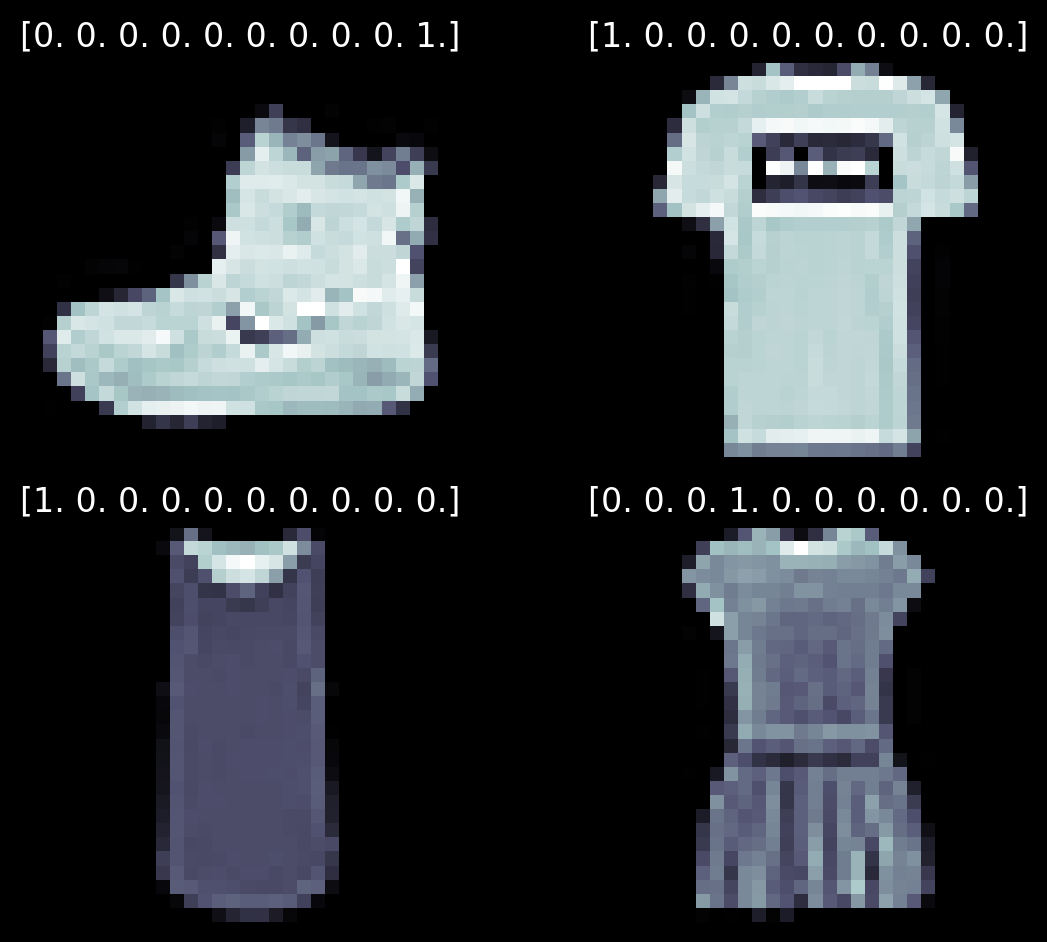

In [6]:
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.ravel()):
    ax.imshow(X_train[i], cmap="bone")
    ax.set_title(y_train[i])
    ax.axis("off")
plt.tight_layout()

In [7]:
dim_in = (28, 28, 1)

In [12]:
class CNN(nn.Module):
    dim_output: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        # x = nn.relu(x)
        x = jnp.sin(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        # x = nn.relu(x)
        x = jnp.sin(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.relu(x)
        x = nn.Dense(features=84, name="last_layer")(x)  # There are 10 classes in MNIST
        x = nn.relu(x)
        x = nn.Dense(self.dim_output, name="output_layer")(x)
        x = jax.nn.softmax(x)
        # x = jax.nn.log_softmax(x)
        # x = x - jax.nn.logsumexp(x)
        return x.squeeze()
    
model = CNN()

## LoFi

In [13]:
X_eval = X_test[:5_000]
y_eval = y_test[:5_000]
def callbackfn(bel_update, bel_prev, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat_eval = agent.link_fn(bel_update.mean, X_eval).argmax(axis=1)
    acc = (yhat_eval == y_eval).mean()
    return acc

In [22]:
%%time
agent = lofi.MultinomialFilter(
    model.apply,
    dynamics_covariance=0.0,
    rank=0
)
params = model.init(key, X_train[:100])


initial_covariance = 5e-2
bel_init = agent.init_bel(params, cov=initial_covariance)
cfn = partial(callbackfn, agent=agent)
bel, hist_lofi_00 = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
# bel, hist_lofi_00 = agent.scan(bel_init, y_train[:1_000], X_train[:1_000], cfn)
bel = jax.block_until_ready(bel)

CPU times: user 26.3 s, sys: 703 ms, total: 27 s
Wall time: 1min 23s


In [17]:
%%time
agent = lofi.MultinomialFilter(
    model.apply,
    dynamics_covariance=0.0,
    rank=10
)
params = model.init(key, X_train[:100])

initial_covariance = 5e-2
bel_init = agent.init_bel(params, cov=initial_covariance)
cfn = partial(callbackfn, agent=agent)
bel, hist_lofi_10 = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
# bel, hist_lofi_10 = agent.scan(bel_init, y_train[:1_000], X_train[:1_000], cfn)
bel = jax.block_until_ready(bel)

CPU times: user 27.9 s, sys: 879 ms, total: 28.8 s
Wall time: 1min 36s


In [19]:
%%time
agent = lofi.MultinomialFilter(
    model.apply,
    dynamics_covariance=0.0,
    rank=1
)
params = model.init(key, X_train[:100])

bel_init = agent.init_bel(params, cov=initial_covariance)
cfn = partial(callbackfn, agent=agent)
bel, hist_lofi_01 = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
# bel, hist_lofi_01 = agent.scan(bel_init, y_train[:1_000], X_train[:1_000], cfn)
bel = jax.block_until_ready(bel)

CPU times: user 27.8 s, sys: 744 ms, total: 28.6 s
Wall time: 1min 24s


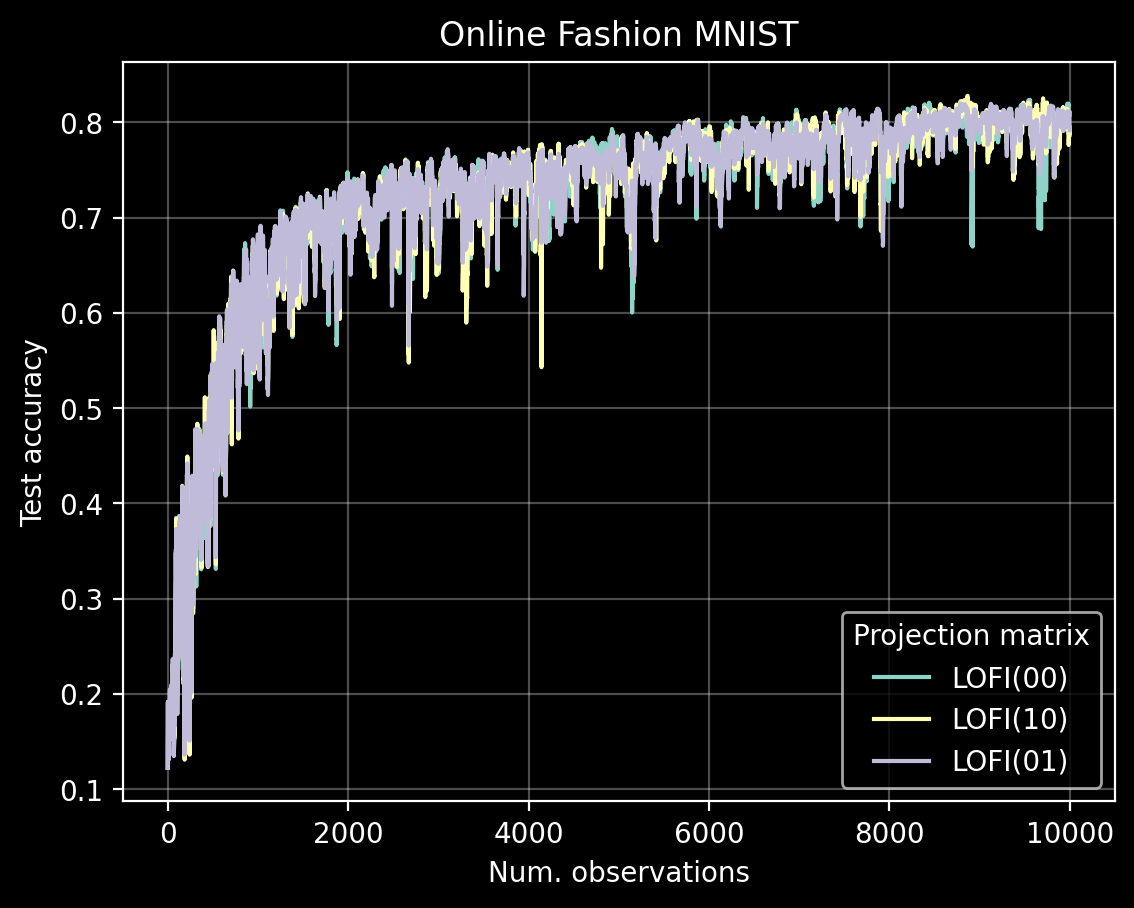

In [27]:
plt.plot(hist_lofi_00, label="LOFI(00)")
plt.plot(hist_lofi_10, label="LOFI(10)")
plt.plot(hist_lofi_01, label="LOFI(01)")
plt.legend(title="Projection matrix")

plt.xlabel("Num. observations")
plt.ylabel("Test accuracy")
plt.title("Online Fashion MNIST")
plt.grid(alpha=0.3)

## Online-sgd

In [28]:
X_eval = X_test[:5_000]
y_eval = y_test[:5_000]
def callbackfn(bel_update, bel_prev, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat_eval = agent.apply_fn(bel_update.mean, X_eval).argmax(axis=1)
    acc = (yhat_eval == y_eval).mean()
    return acc

In [29]:
def lossfn_fifo_sgd(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    num = -(y * yhat).sum(axis=1) * counter
    return num.sum() / counter.sum()

In [30]:
agent = replay_sgd.FifoSGD(
    model.apply,
    lossfn_fifo_sgd,
    optax.adam(1e-4),
    buffer_size=1,
    dim_features=(28, 28, 1),
    dim_output=10,
    n_inner=1
)

In [31]:
%%time
params_init = model.init(key, X_train[:10])
bel_init = agent.init_bel(params_init)

cfn = partial(callbackfn, agent=agent)
bel_osgd, hist_osgd = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
# bel_osgd, hist_osgd = agent.scan(bel_init, y_train[:1_000], X_train[:1_000], cfn)
bel_osgd = jax.block_until_ready(bel_osgd)

CPU times: user 14.6 s, sys: 227 ms, total: 14.9 s
Wall time: 1min 7s


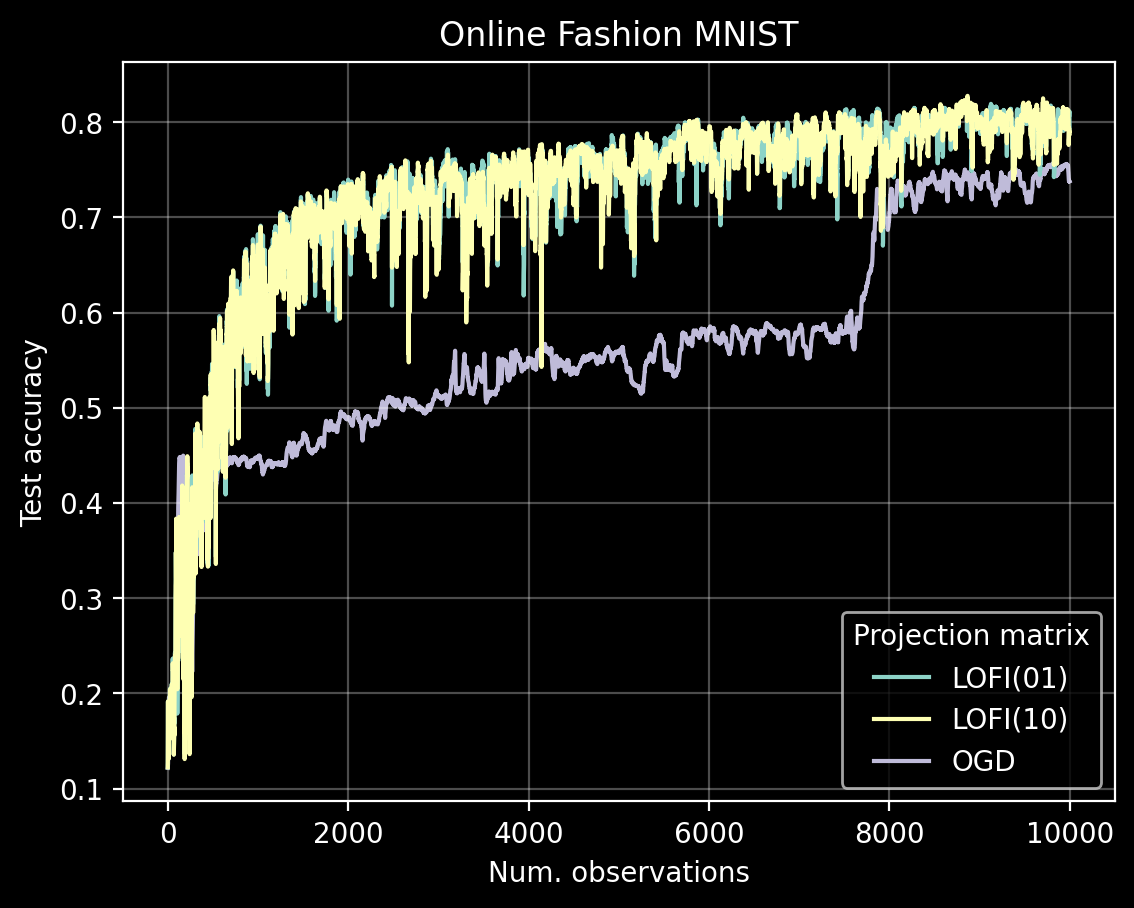

In [32]:
plt.plot(hist_lofi_01, label="LOFI(01)")
plt.plot(hist_lofi_10, label="LOFI(10)")
plt.plot(hist_osgd, label="OGD", zorder=0)

plt.legend(title="Projection matrix")


plt.xlabel("Num. observations")
plt.ylabel("Test accuracy")
plt.title("Online Fashion MNIST")
plt.grid(alpha=0.3)

## Replay-buffer SGD 

In [33]:
def lossfn_fifo_sgd(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    num = -(y * yhat).sum(axis=1) * counter
    return num.sum() / counter.sum()

In [34]:
agent = replay_sgd.FifoSGD(
    model.apply,
    lossfn_fifo_sgd,
    optax.adam(1e-4),
    buffer_size=10,
    dim_features=(28, 28, 1),
    dim_output=10,
    n_inner=1
)

In [35]:
params_init = model.init(key, X_train[:10])

In [36]:
bel_init = agent.init_bel(params_init)

In [37]:
%%time
cfn = partial(callbackfn, agent=agent)
bel_rsgd, hist_rsgd = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
bel_rsgd = jax.block_until_ready(bel_rsgd)

CPU times: user 10.2 s, sys: 80 ms, total: 10.3 s
Wall time: 1min 7s


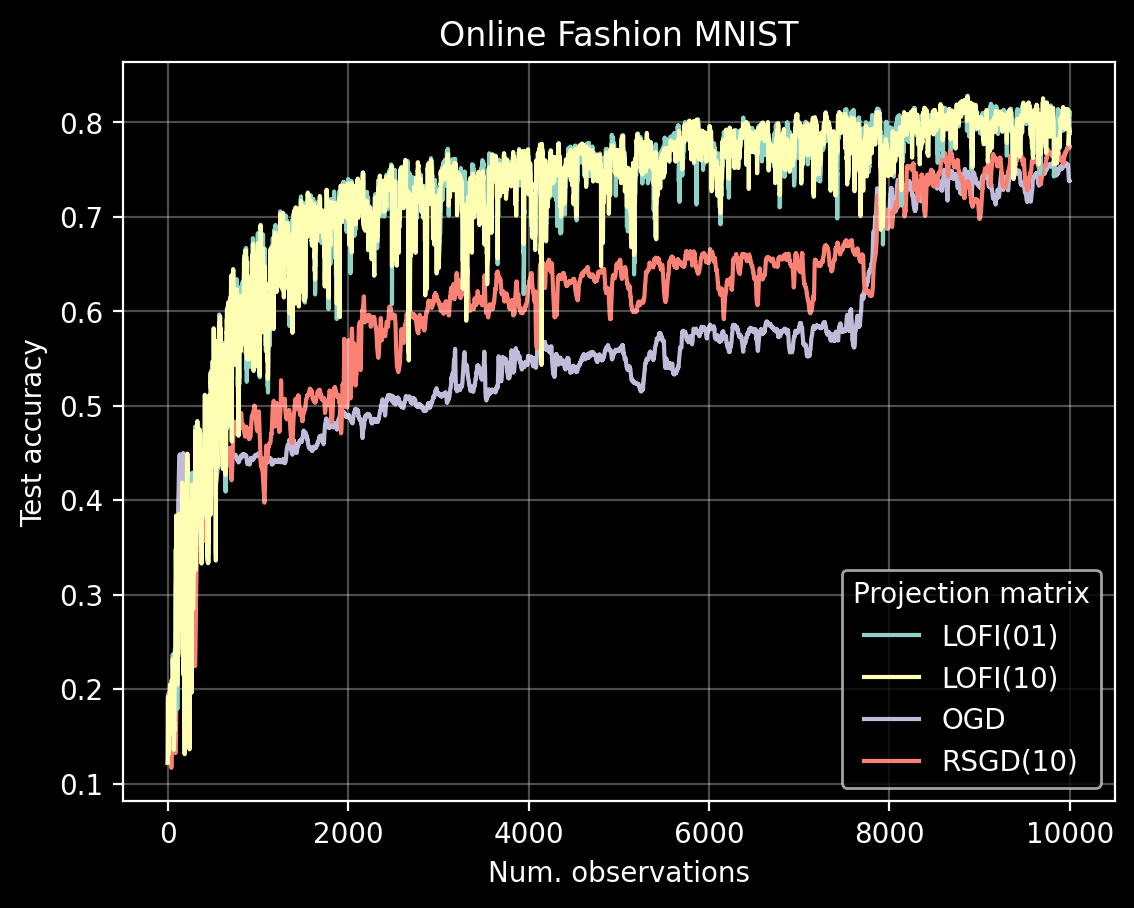

In [38]:
plt.plot(hist_lofi_01, label="LOFI(01)")
plt.plot(hist_lofi_10, label="LOFI(10)")
plt.plot(hist_osgd, label="OGD", zorder=0)
plt.plot(hist_rsgd, label="RSGD(10)", zorder=0)

plt.legend(title="Projection matrix")


plt.xlabel("Num. observations")
plt.ylabel("Test accuracy")
plt.title("Online Fashion MNIST")
plt.grid(alpha=0.3)